In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist
import seaborn as sns

import optuna
import numpy as np

In [21]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 

In [22]:
df_normal = df[['stdR', 'kurB']].copy()

### Preprocessing

In [23]:
#Standarization
scaler = MinMaxScaler()

df_minmax = scaler.fit_transform(df_normal.copy())
df_minmax = pd.DataFrame(df_minmax, columns=df_normal.columns)

df_minmax.head(3)

,stdR,kurB
0,0.309574,0.202234
1,0.320018,0.211744
2,0.454159,0.182167


In [24]:
X_train = df_minmax.copy()
y_train = df['Class']


###Building Model

In [ ]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        D = np.linalg.norm(self.w - x, axis=1)
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)

            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

In [ ]:
X_train_np = X_train.values  

m = 6
fitur = X_train_np.shape[1]  
R = 4
alpha0 = 0.1
tau = 500

som_normal = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

n_iterations = 1000
som_normal.train(X_train_np, n_iterations)

weights_normal = som_normal.w
print("Trained SOM weights:", weights_normal)

Trained SOM weights: [[0.72435395 0.08372442]
 [0.61643015 0.12447916]
 [0.50679311 0.15010461]
 [0.42572411 0.18094005]
 [0.33402719 0.19570872]
 [0.25660664 0.24924518]]


In [27]:
def plot_cluster(som, data):
    bmu_indices = [som.hitung_bmu(x) for x in data]

    plt.figure(figsize=(8, 6))

    for i in range(som.m):
        cluster_points = data[np.array(bmu_indices) == i]
        if len(cluster_points) > 0:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Kluster {i}", s=20, alpha=0.7)

    plt.scatter(som.w[:, 0], som.w[:, 1], c='red', label='Neuron SOM', s=100, marker='o')

    for i in range(som.m - 1):
        plt.plot([som.w[i, 0], som.w[i + 1, 0]], [som.w[i, 1], som.w[i + 1, 1]], color='red')

    plt.title("Cluster Plot berdasarkan BMU (Fitur dengan Varians Tertinggi)")
    plt.xlabel("Fitur 1")
    plt.ylabel("Fitur 2")
    plt.legend()
    plt.grid()
    plt.show()

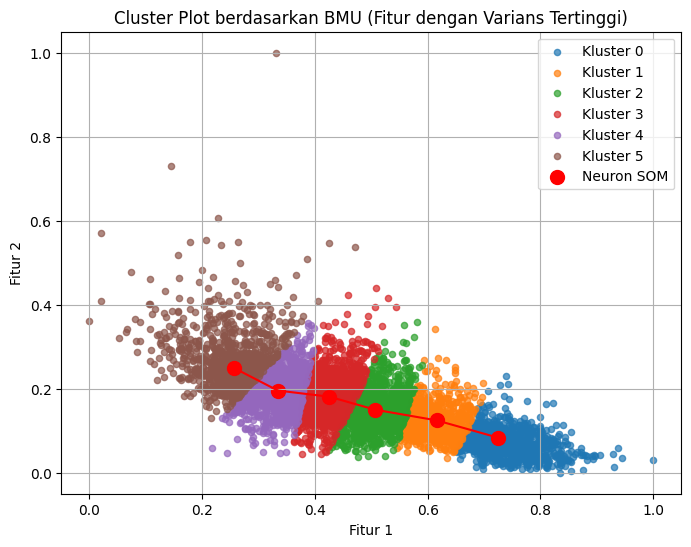

In [28]:
plot_cluster(som_normal, X_train_np)

## Evaluasi Sebelum Tuning

In [29]:
def qete(som, data):
    qe = som.quantization_error(data)
    te = som.topographic_error(data)

    return print("Quantization Error (QE):", qe, "\nTopographic Error (TE)", te)
    

In [30]:
qete(som_normal, X_train_np)

Quantization Error (QE): 0.05447503417225867 
Topographic Error (TE) 0.0001768033946251768


In [31]:
def silhouette(som, data):
    bmu_indices = [som.hitung_bmu(x) for x in data]

    cluster_labels = np.array(bmu_indices)

    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

In [32]:
silhouette(som_normal,X_train_np)

Silhouette Score: 0.3235


## Evaluasi Setelah Tuning

In [33]:
X_train_optuna = X_train.values  

m = 6
fitur = X_train_optuna.shape[1]  
R = 4.233316945750336
alpha0 = 0.22571970085686788
tau = 295
n_iterations = 1154

som_optuna = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

som_optuna.train(X_train_optuna, n_iterations)

weights_optuna = som_optuna.w
print("Trained SOM weights:", weights_optuna)

Trained SOM weights: [[0.72999765 0.07784927]
 [0.5520138  0.12861789]
 [0.47979847 0.20676621]
 [0.39329932 0.18756525]
 [0.30246566 0.18581634]
 [0.25644297 0.28522023]]


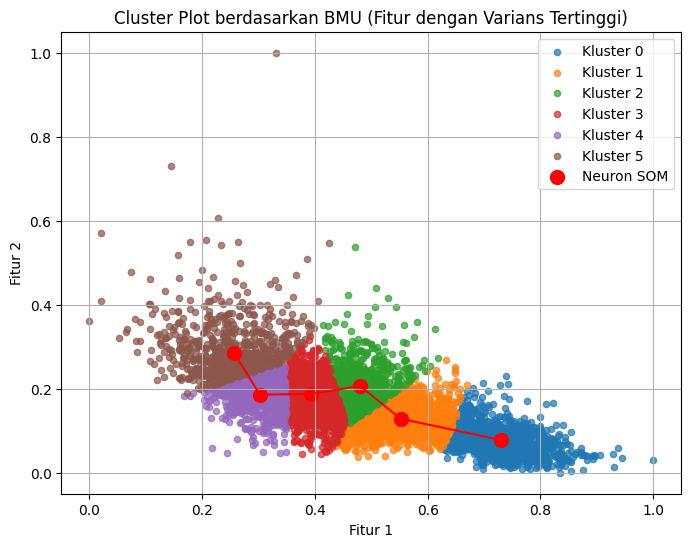

In [34]:
plot_cluster(som_optuna, X_train_optuna)

In [35]:
qete(som_optuna,X_train_optuna)

Quantization Error (QE): 0.055124096062299635 
Topographic Error (TE) 0.019625176803394626


In [36]:
silhouette(som_optuna,X_train_optuna)

Silhouette Score: 0.3377


### Analisis Lebih Lanjut

In [39]:
def profil_kluster(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    profil = df.groupby('kluster').agg(['mean', 'std', 'min', 'max'])
    return profil

profil_kluster_result = profil_kluster(som_optuna, X_train_optuna)
print("Profil Kluster:\n", profil_kluster_result)

Profil Kluster:
                 0                                       1                      \
             mean       std       min       max      mean       std       min   
kluster                                                                         
0        0.733795  0.057189  0.629450  1.000000  0.075977  0.035638  0.000000   
1        0.555413  0.048609  0.438074  0.669112  0.126345  0.034781  0.038062   
2        0.480249  0.033056  0.413501  0.617856  0.203724  0.052144  0.118010   
3        0.396238  0.027249  0.347458  0.451738  0.179522  0.048039  0.043457   
4        0.297431  0.034275  0.166958  0.349402  0.185264  0.037467  0.046135   
5        0.248022  0.064389  0.000000  0.425716  0.297162  0.067605  0.190693   

                   
              max  
kluster            
0        0.231160  
1        0.267501  
2        0.536373  
3        0.324606  
4        0.259552  
5        1.000000  


In [40]:
from scipy import stats

def identifikasi_fitur_penting(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    fitur_penting = {}
    
    for i in range(data.shape[1]): 
        grup = [df[df['kluster'] == k].iloc[:, i] for k in range(som.m)]
        
        f_stat, p_value = stats.f_oneway(*grup)
        
        fitur_penting[f'Fitur {i}'] = {'F-statistic': f_stat, 'p-value': p_value}
    
    return fitur_penting


fitur_penting_result = identifikasi_fitur_penting(som_optuna, X_train_optuna)

for fitur, hasil in fitur_penting_result.items():
    print(f"{fitur}: F-statistic = {hasil['F-statistic']:.4f}, p-value = {hasil['p-value']:.4f}")

Fitur 0: F-statistic = 13891.4868, p-value = 0.0000
Fitur 1: F-statistic = 2280.0123, p-value = 0.0000


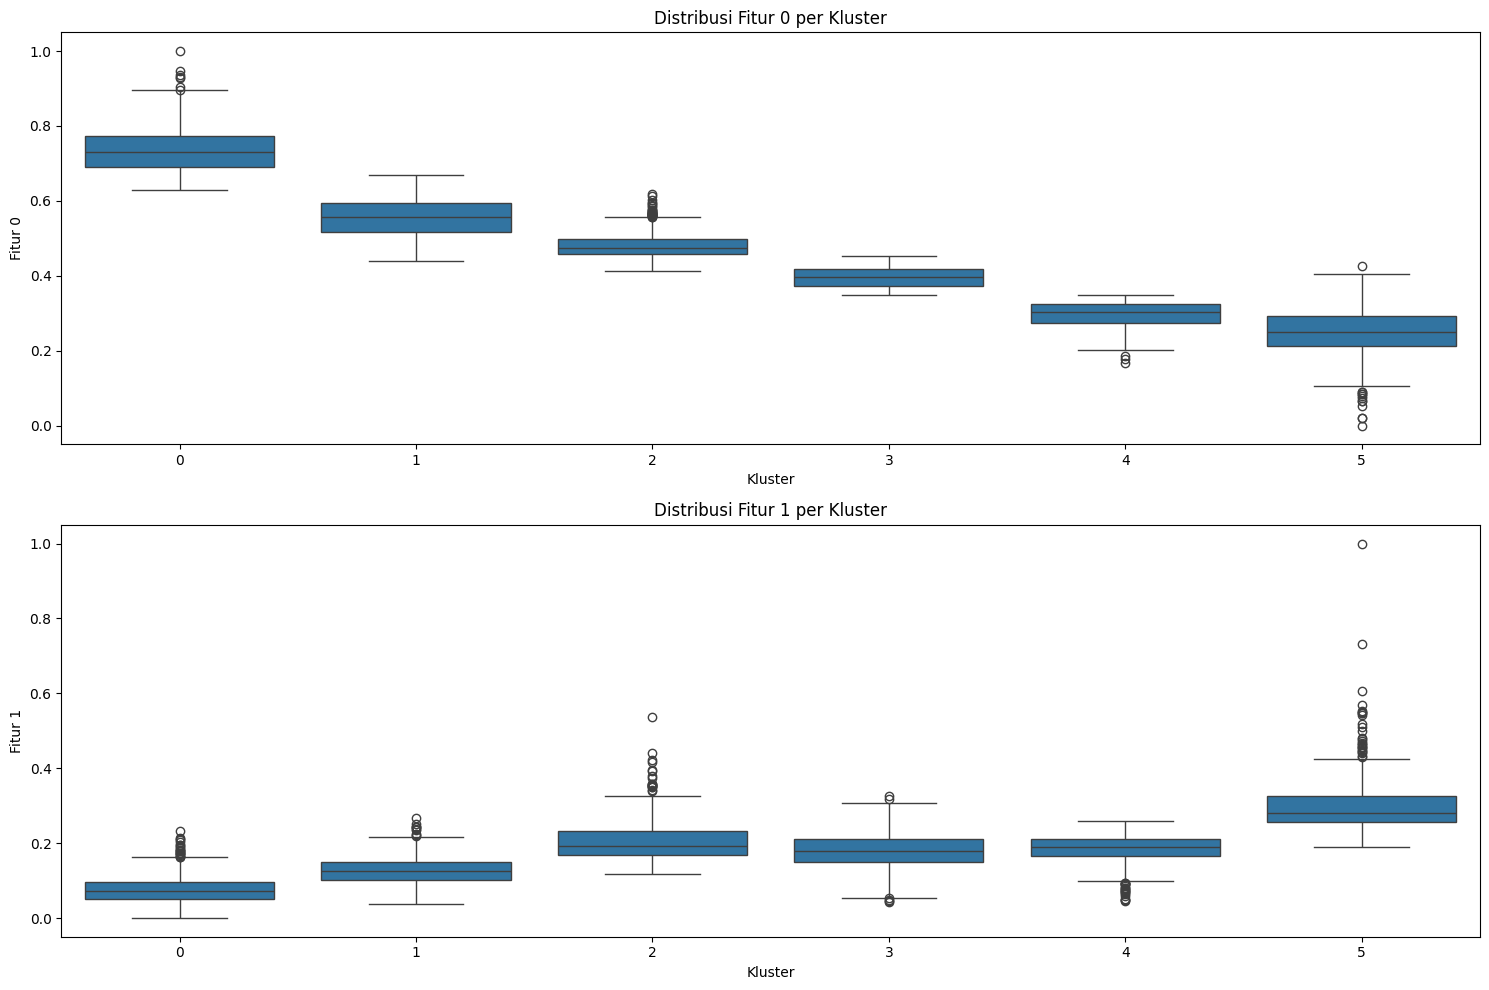

In [37]:
def visualisasi_distribusi_fitur(som, data):
    kluster = [som.hitung_bmu(x) for x in data]
    df = pd.DataFrame(data)
    df['kluster'] = kluster
    
    plt.figure(figsize=(15, 10))
    
    for i in range(data.shape[1]):
        plt.subplot(2, (data.shape[1] + 1) // 2, i + 1)  
        sns.boxplot(x='kluster', y=df.columns[i], data=df)
        plt.title(f'Distribusi Fitur {i} per Kluster')
        plt.xlabel('Kluster')
        plt.ylabel(f'Fitur {i}')
    
    plt.tight_layout()
    plt.show()

visualisasi_distribusi_fitur(som_optuna, X_train_optuna)

In [ ]:

# weights_optuna = som_optuna.w  

# weights_somperf = weights_optuna.reshape(-1, fitur) 

# map_size = (m, 1)  
# topology_dist = rectangular_topology_dist(map_size)

# topographic_prod = topographic_product(topology_dist, weights_somperf)
# neighborhood_pres = neighborhood_preservation(1, weights_somperf, X_train_optuna)
# trustworthiness_score = trustworthiness(1, weights_somperf, X_train_optuna)

# print(f"Topographic Product = {topographic_prod}")
# print(f"Neighborhood Preservation = {neighborhood_pres}")
# print(f"Trustworthiness = {trustworthiness_score}")

Topographic Product = 0.00884164250924906
Neighborhood Preservation = -2.9373520905453527
Trustworthiness = 0.8549309845256001


## Tuning

In [39]:
def objective(trial):
    m = trial.suggest_int('m', 2, 6) 
    R = trial.suggest_float('R', 0.1, 5.0)
    alpha0 = trial.suggest_float('alpha0', 0.01, 0.5) 
    tau = trial.suggest_int('tau', 100, 2000) 
    n_iterations = trial.suggest_int("n_iterations", 500, 1500)

    som = SOMlinier(m=m, fitur=X_train_np.shape[1], R=R, alpha=alpha0, tau=tau)
    som.train(X_train_np, n_iterations)

    qe = som.quantization_error(X_train_np)
    te = som.topographic_error(X_train_np)

    return qe + te

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best Parameters (Optuna):", study.best_params)
print("Best Score (QE + TE):", study.best_value)


[I 2024-11-21 00:05:34,308] A new study created in memory with name: no-name-93167846-768e-473f-b9a7-dec5adf095d4


[I 2024-11-21 00:05:34,426] Trial 0 finished with value: 0.06404905013952401 and parameters: {'m': 4, 'R': 3.0427520685869087, 'alpha0': 0.12774972000852028, 'tau': 785, 'n_iterations': 1311}. Best is trial 0 with value: 0.06404905013952401.
[I 2024-11-21 00:05:34,532] Trial 1 finished with value: 0.1405139830023648 and parameters: {'m': 5, 'R': 1.246499182941305, 'alpha0': 0.011208478336564886, 'tau': 1363, 'n_iterations': 665}. Best is trial 0 with value: 0.06404905013952401.
[I 2024-11-21 00:05:34,652] Trial 2 finished with value: 0.09382008177900415 and parameters: {'m': 6, 'R': 1.7446446943864014, 'alpha0': 0.49930856614896524, 'tau': 585, 'n_iterations': 1470}. Best is trial 0 with value: 0.06404905013952401.
[I 2024-11-21 00:05:34,765] Trial 3 finished with value: 0.1537431607972475 and parameters: {'m': 2, 'R': 3.8832119920565478, 'alpha0': 0.38233213610330163, 'tau': 1355, 'n_iterations': 958}. Best is trial 0 with value: 0.06404905013952401.
[I 2024-11-21 00:05:34,866] Trial 

Best Parameters (Optuna): {'m': 6, 'R': 2.907648004019947, 'alpha0': 0.1701774197840329, 'tau': 318, 'n_iterations': 1380}
Best Score (QE + TE): 0.05410671103225653
